In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../../funcs')
from xarray_tools import find_cor_ts
from plotting import map_grid_clean, plt_lc

In [9]:
fig_dir = Path('/bsuhome/zacharykeskinen/uavsar-coherence/figures')

In [2]:
dss = {fp.stem: xr.open_dataset(fp) for fp in Path('~/scratch/coherence/uavsar').expanduser().glob('*_tau.nc')}
ds = dss['rockmt_v3_tau']

In [3]:
import matplotlib.colors

class FixPointNormalize(matplotlib.colors.Normalize):
    """ 
    Inspired by https://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib
    Subclassing Normalize to obtain a colormap with a fixpoint 
    somewhere in the middle of the colormap.

    This may be useful for a `terrain` map, to set the "sea level" 
    to a color in the blue/turquise range. 
    """
    def __init__(self, vmin=None, vmax=None, sealevel=0, col_val = 0.21875, clip=False):
        # sealevel is the fix point of the colormap (in data units)
        self.sealevel = sealevel
        # col_val is the color value in the range [0,1] that should represent the sealevel.
        self.col_val = col_val
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.sealevel, self.vmax], [0, self.col_val, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Combine the lower and upper range of the terrain colormap with a gap in the middle
# to let the coastline appear more prominently.
# inspired by https://stackoverflow.com/questions/31051488/combining-two-matplotlib-colormaps
colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 56))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 200))
# combine them and build a new colormap
colors = np.vstack((colors_undersea, colors_land))
cut_terrain_map = matplotlib.colors.LinearSegmentedColormap.from_list('cut_terrain', colors_land)

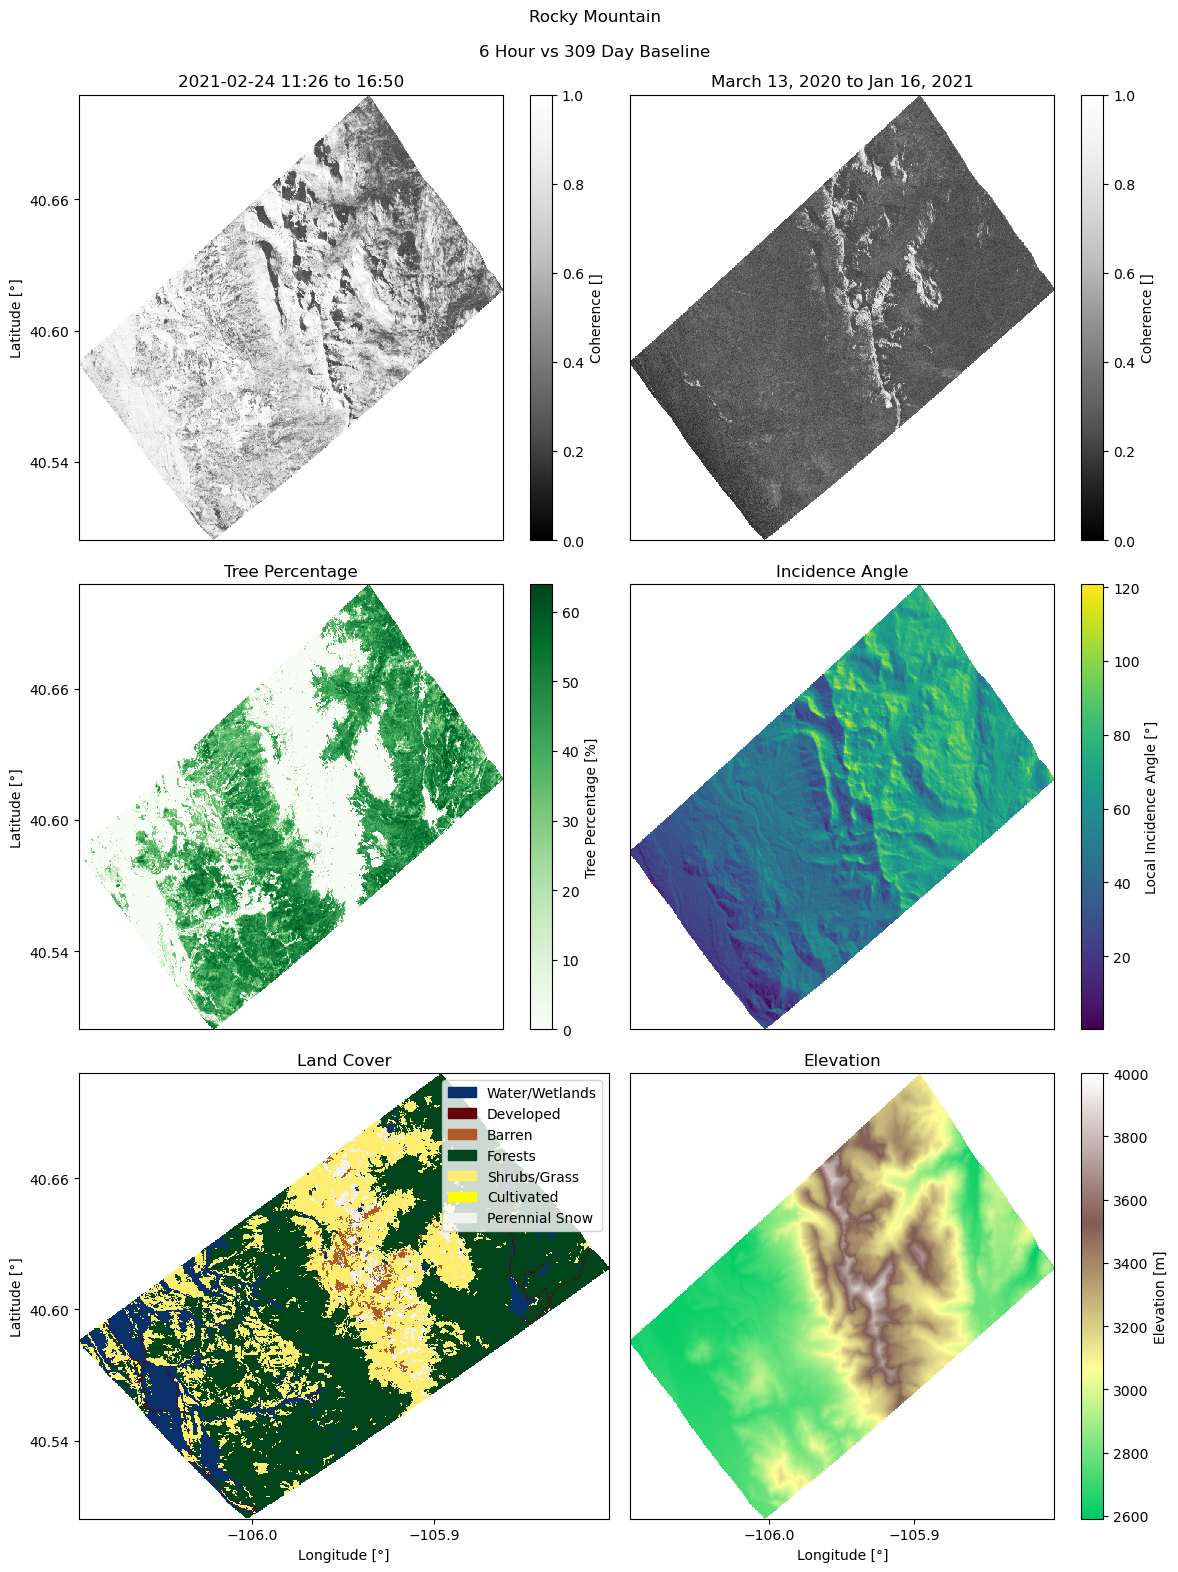

In [10]:
fig, axes = plt.subplots(3,2, figsize = (12, 16))

short = ds.sel(time1= '2021-02-24T00:00:00.000000000', time2 = '2021-02-24T00:00:00.000000000', heading = 141).sel(pol = 'VV')['cor'].where(~ds['inc'].sel(heading = 141).isnull()).dropna('x', how = 'all').dropna('y', how = 'all')
long = ds.sel(time1= '2020-03-13T00:00:00.000000000', time2 = '2021-01-16T00:00:00.000000000', heading = 141).sel(pol = 'VV').where(~short.isnull())['cor']
short.plot(ax = axes[0, 0], cbar_kwargs = {'label': 'Coherence []'}, vmin = 0, vmax = 1, cmap = 'Greys_r')
long.plot(ax = axes[0, 1], cbar_kwargs = {'label': 'Coherence []'}, vmin = 0, vmax = 1, cmap = 'Greys_r')
ds['tree_perc'].where(~short.isnull()).plot(ax = axes[1, 0], cbar_kwargs = {'label': 'Tree Percentage [%]'}, cmap = 'Greens')
np.rad2deg(ds['inc'].sel(heading = 141).where(~short.isnull())).plot(ax = axes[1,1], cbar_kwargs = {'label': 'Local Incidence Angle [°]'})

plt_lc(ds['land_cover'].where(~short.isnull()), ax = axes[2, 0])
ds['dem'].where(~short.isnull()).plot(ax = axes[2, 1], cbar_kwargs = {'label': 'Elevation [m]'}, cmap = cut_terrain_map, vmax = 4000) #, vmin = 2000, vmax = 4000)

for ax, title in zip(axes.ravel(), ['2021-02-24 11:26 to 16:50', 'March 13, 2020 to Jan 16, 2021', 'Tree Percentage', 'Incidence Angle', 'Land Cover', 'Elevation']):
    ax.set_title(title)

map_grid_clean(axes)
plt.suptitle('Rocky Mountain\n\n6 Hour vs 309 Day Baseline\n')
plt.tight_layout()
plt.savefig(fig_dir.joinpath('examples', '6hr_309d_ex.png'))

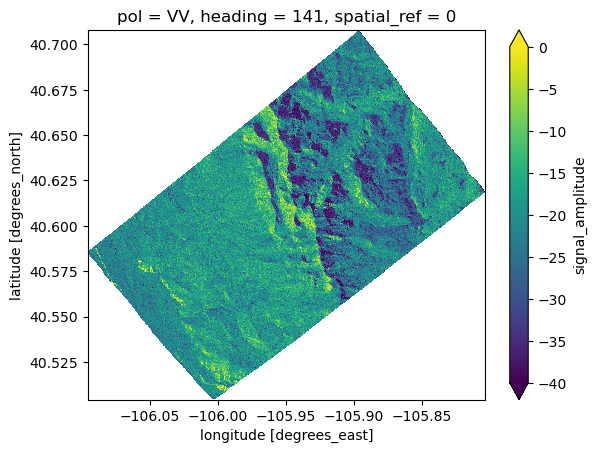

In [8]:
ds['signal_amplitude'].sel(time1= '2020-03-13T00:00:00.000000000', time2 = '2021-01-16T00:00:00.000000000', heading = 141).sel(pol = 'VV').where(~short.isnull()).plot(vmax = 0, vmin = -40)